# Kinematics and morphology for males and females

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from aging.plotting import (
    format_plots,
    save_factory,
    figure,
    PLOT_CONFIG,
    COLORMAPS,
)

In [2]:
format_plots()
saver = save_factory(PLOT_CONFIG.save_path / "fig1-panels", tight_layout=False)

In [3]:
def compute_kinematics(df):
    mean_angular_speed = (df["angle"].diff(3) / 3).abs().mean() * 30
    mean_velocity = (
        df["velocity_2d_mm"]
        .rolling(3, center=True, min_periods=1, win_type="gaussian")
        .mean(std=0.5)
        .mean()
    ) * 30 / 100
    mean_3d_velocity = (
        df["velocity_3d_mm"]
        .rolling(3, center=True, min_periods=1, win_type="gaussian")
        .mean(std=0.5)
        .mean()
    ) * 30 / 100
    return pd.Series(dict(angular=mean_angular_speed, two_d=mean_velocity, three_d=mean_3d_velocity))


def compute_dist_to_center(df):
    center_x = (df['centroid_x_mm'].max() - df['centroid_x_mm'].min()) / 2
    center_y = (df['centroid_y_mm'].max() - df['centroid_y_mm'].min()) / 2

    distance_x = df['centroid_x_mm'] - center_x
    distance_y = df['centroid_y_mm'] - center_y

    dist_to_center = np.sqrt(distance_x ** 2 + distance_y ** 2)

    return pd.Series(dict(center_distance=dist_to_center.mean()))

In [4]:
agg_kin_df = []
agg_size_df = []

In [5]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_syllable_df_v00.parquet')
df = df.query('age < 100')
kin_df = df.groupby(['age', 'uuid'], sort=False)[['angle', 'velocity_2d_mm', 'velocity_3d_mm']].apply(compute_kinematics)
_ddf = df.groupby(['age', 'uuid'], sort=False)[['centroid_x_mm', 'centroid_y_mm']].apply(compute_dist_to_center)
kin_df = kin_df.join(_ddf)
kin_df['exp'] = 'males'

agg_kin_df.append(kin_df)

size_df = df.groupby(['age', 'uuid'], sort=False)[['height_ave_mm', 'area_mm', 'width_mm']].mean()
size_df['area_mm'] = size_df['area_mm'] / 100
# size_df['exp'] = 'males'

agg_size_df.append(size_df)

In [6]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_syllable_df_v00.parquet')
df = df.query('age < 100')
kin_df = df.groupby(['age', 'uuid'], sort=False)[['angle', 'velocity_2d_mm', 'velocity_3d_mm']].apply(compute_kinematics)
_ddf = df.groupby(['age', 'uuid'], sort=False)[['centroid_x_mm', 'centroid_y_mm']].apply(compute_dist_to_center)
kin_df = kin_df.join(_ddf)
kin_df['exp'] = 'females'
kin_df = kin_df.query('angular > 0.1')

agg_kin_df.append(kin_df)

size_df = df.groupby(['age', 'uuid'], sort=False)[['height_ave_mm', 'area_mm', 'width_mm']].mean()
size_df['area_mm'] = size_df['area_mm'] / 100
# size_df['exp'] = 'females'
size_df = size_df.query('area_mm > 1')

agg_size_df.append(size_df)

In [7]:
agg_kin_df = pd.concat(agg_kin_df)
agg_size_df = pd.concat(agg_size_df)

In [8]:
agg_df = agg_kin_df.join(agg_size_df)

In [9]:
ylabel_map = dict(
    angular="Angular speed (rad/s)", two_d="2D speed (cm/s)", three_d="3D speed (cm/s)", center_distance="Dist. to center (mm)",
    area_mm="Area (cm2)", height_ave_mm="Height (mm)", width_mm="Width (mm)",
)


webf NOT subset; don't know how to subset; dropped


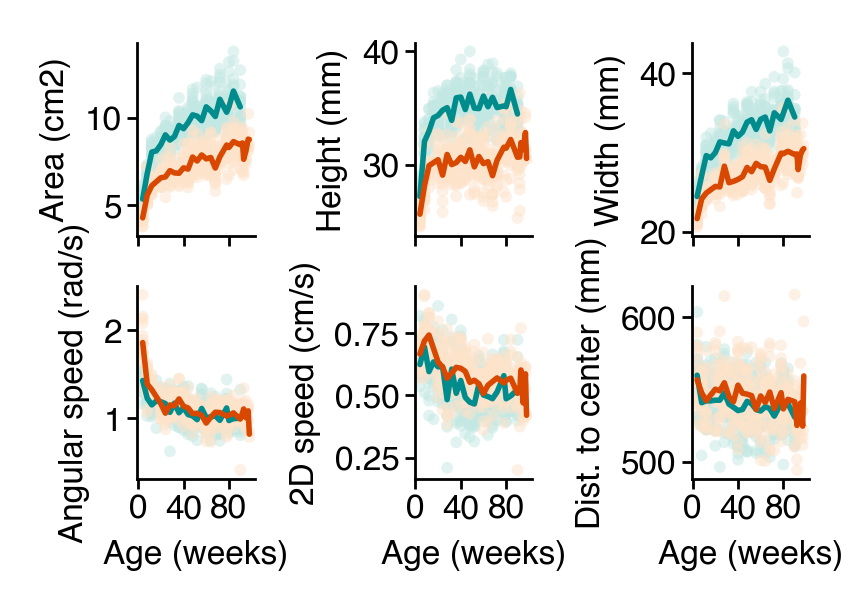

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(2.1, 1.5), sharex=True)
for a, k in zip(ax.flat, ("area_mm", "height_ave_mm", "width_mm", "angular", "two_d", "center_distance")):
    a = sns.scatterplot(
        data=agg_df.reset_index(),
        x="age",
        y=k,
        hue='exp',
        linewidths=0,
        s=4.5,
        zorder=-1,
        palette=[COLORMAPS.ont_male(5), COLORMAPS.ont_female(5)],
        hue_order=['males', 'females'],
        ax=a,
        alpha=0.5,
        legend=False,
    )
    a = sns.lineplot(
        data=agg_df.reset_index(),
        x="age",
        y=k,
        hue='exp',
        errorbar=None,
        # err_kws=dict(lw=0, alpha=0.3),
        palette=[COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)],
        hue_order=['males', 'females'],
        ax=a,
        # legend=k == "width_mm",
        legend=False,
    )
    a.set(ylabel=ylabel_map[k], xlabel="Age (weeks)", xticks=[0, 40, 80])
sns.despine()
saver(fig, "mf-kinematics-and-morphology-over-age", tight_layout=True);